In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

pragyaaa06_dataset1_path = kagglehub.dataset_download('pragyaaa06/dataset1')
pragyaaa06_dataset2_path = kagglehub.dataset_download('pragyaaa06/dataset2')
pragyaaa06_dataset3_path = kagglehub.dataset_download('pragyaaa06/dataset3')

print('Data source import complete.')


In [ ]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

df=pd.read_csv('/kaggle/input/dataset3/big_corpus.csv')
df.head()


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1.0,False,"10 22, 2008",A74TA8X5YQ7NE,B000X9FV5M,NeuroSplicer,Recently UBISOFT had to settle a huge class-ac...,THE DAY GAMING CRIED...,1224633600,NaN,{'Format:': ' Video Game'},NaN
1,1.0,True,"03 17, 2018",A2EYD6E0TFQPVL,B014G03F24,chris,"code didn't work, got me a refund.",One Star,1521244800,NaN,NaN,NaN
2,1.0,True,"02 22, 2017",A303LKXI2SAZQ4,B003OAE79S,tammy,"these do not work at all, all i get is static ...","these do not work at all, all i get ...",1487721600,NaN,{'Size:': ' one size'},NaN
3,1.0,False,"03 23, 2012",A1JGSUX59ZTWYE,B004UDLRMS,Bear,well let me start by saying that when i first ...,last gen game,1332460800,6,{'Format:': ' Video Game'},NaN
4,1.0,False,"05 16, 2008",AXIVHIP86D1MJ,B0013B30SY,Mustang,"Dont waste your money, you will just end up us...",Waste,1210896000,4,NaN,NaN


In [ ]:
df.isnull().sum()

overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
reviewerName          53
reviewText            30
summary               21
unixReviewTime         0
vote               78093
style              45592
image             109198
dtype: int64

In [ ]:
df.dropna(subset=['reviewText'], inplace=True)
df.shape

(109970, 12)

In [ ]:
df['overall'].value_counts()

overall
5.0    34977
1.0    24996
4.0    20000
2.0    14999
3.0    14998
Name: count, dtype: int64

In [ ]:
# text cleaning
def clean_text(text):
    text=text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

df['cleaned_review'] = df['reviewText'].apply(clean_text)

In [ ]:
# create sentiment labels
def map_sentiment(rating):
  if rating<=2:
    return 0 # negative
  elif rating==3:
    return 1 # neutral
  else:
    return 2 # positive

df['sentiment']=df['overall'].apply(map_sentiment)

In [ ]:
reviews=df['cleaned_review'].values
labels=df['sentiment'].values
print('Data cleaning and labeling complete.')
print('Example review:', reviews[0])
print('Example label:', labels[0])

Data cleaning and labeling complete.
Example review: recently ubisoft had to settle a huge classaction suit brought against the company for bundling the notoriously harmful starforce drm with its released games so what the geniuses at the helm do next they decide to make the same mistake yet again  by choosing the same drm scheme that made bioshock mass effect and spore infamous securom xx with limited activations

mass effect can be found in clearance bins only months after its release spore not only undersold miserably but also made history as the boiling point of gamers lashing back fed up with idiotic drm schemes and the clueless mbas that run an artform as any other commodity business decided that hey why not jump into that mudpond ourselves

the original far cry was such a great game that any sequel of it would have to fight an uphill battle to begin with especially without its original developing team now imagine shooting this sequel on the foot with a well known much hated and 

In [ ]:
# Tokenization
voc_size=10000
tokenizer=Tokenizer(num_words=voc_size, oov_token='<OOV>')
tokenizer.fit_on_texts(reviews)
# convert text to sequences of integers
sequences=tokenizer.texts_to_sequences(reviews)

In [ ]:
# Padding
max_len = int(np.percentile([len(seq) for seq in sequences], 95))
padded_sequences=pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
print(f"Vocabulary size: {voc_size}")
print(f"Maximum sequence length: {max_len}")
print(f"Padded sequence shape: {padded_sequences.shape}")

Vocabulary size: 10000
Maximum sequence length: 554
Padded sequence shape: (109970, 554)


In [ ]:
X_train, X_test, y_train, y_test=train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# coverts labels to categorical for the model
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)


In [ ]:
# Building the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

embedding_dim = 128
model= Sequential([
    Embedding(voc_size,output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size=128
early_stopping=EarlyStopping(monitor='val_loss',min_delta=0.001, patience=3, restore_best_weights=True)
print('Training the model....')

history=model.fit(
    X_train,y_train,
    epochs=20,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping]
)
print('Training Completed!')

Training the model....
Epoch 1/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 105s 180ms/step - accuracy: 0.6477 - loss: 0.8190 - val_accuracy: 0.7287 - val_loss: 0.6591
Epoch 2/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 103s 188ms/step - accuracy: 0.7527 - loss: 0.6337 - val_accuracy: 0.7707 - val_loss: 0.5920
Epoch 3/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 103s 188ms/step - accuracy: 0.7816 - loss: 0.5607 - val_accuracy: 0.7760 - val_loss: 0.5832
Epoch 4/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 103s 188ms/step - accuracy: 0.7970 - loss: 0.5244 - val_accuracy: 0.7821 - val_loss: 0.5631
Epoch 5/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 103s 188ms/step - accuracy: 0.8111 - loss: 0.4891 - val_accuracy: 0.7664 - val_loss: 0.6180
Epoch 6/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 103s 188ms/step - accuracy: 0.8048 - loss: 0.5012 - val_accuracy: 0.7716 - val_loss: 0.5974
Epoch 7/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 103s 187ms/step - accuracy: 0.7916 - loss: 0.5271 - val_accuracy: 0.7777 - val_loss: 0.5808
Training Completed!


## Checking the overall accuracy

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

loss,accuracy=model.evaluate(X_test,y_test)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

688/688 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.7730 - loss: 0.5846
Test Loss: 0.5808
Test Accuracy: 77.33%


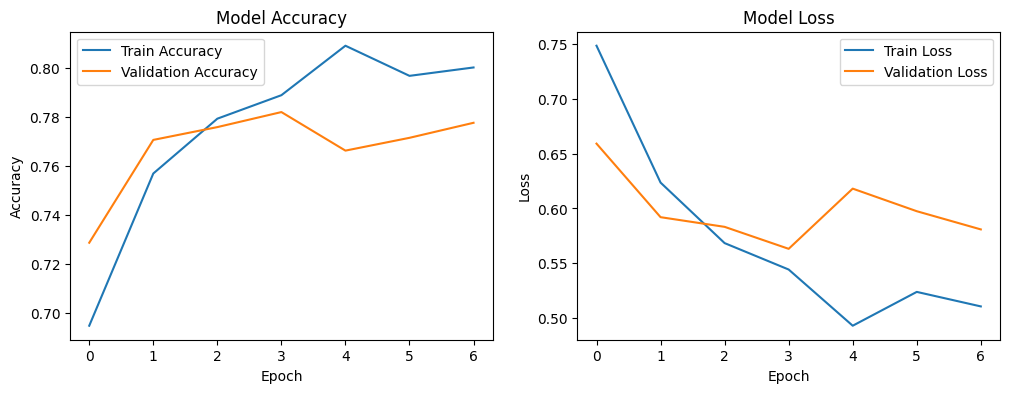

In [ ]:
# plot training history
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    plt.show()
plot_history(history)

Classification Report:
688/688 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step
              precision    recall  f1-score   support

    Negative       0.77      0.84      0.81      8105
     Neutral       0.42      0.10      0.16      3050
    Positive       0.79      0.91      0.85     10839

    accuracy                           0.77     21994
   macro avg       0.66      0.62      0.61     21994
weighted avg       0.73      0.77      0.74     21994

Confusion Matrix:
688/688 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step


<Axes: >

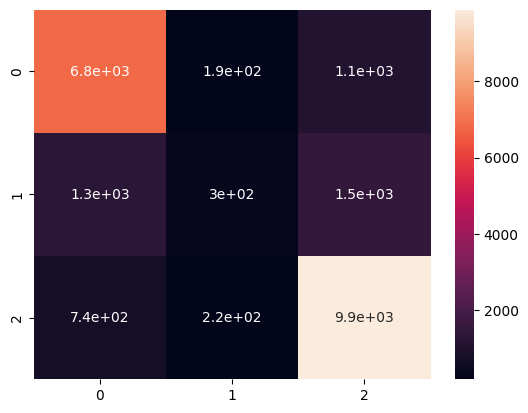

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1), target_names=['Negative', 'Neutral','Positive']))

print("Confusion Matrix:")
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))
sns.heatmap(cm, annot=True)